In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, average_precision_score
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

### We will try to solve the problem using XGBoost as an Ensemble model

#### Loading Pre-processed Dataset & Training/Eval function

In [3]:
# Load dataset from CSV
csv_file = 'Dataset/cleaned.csv' 
df = pd.read_csv(csv_file)

# Separate features and target
y = df['anomaly'].values
X = df.drop(columns=['anomaly']).values

# Save meter_reading column separately
meter_reading = df['meter_reading'].values

# Scale the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [4]:
# Train/Test split with stratification
X_train, X_test, y_train, y_test, meter_train, meter_test = train_test_split(
    X, y, meter_reading, test_size=0.2, random_state=42, stratify=y)

print(len(y_train[y_train == 1]), len(y_train[y_train == 0]))
print(len(y_test[y_test == 1]), len(y_test[y_test == 0]))

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

29837 1369758
7459 342440
(1399595, 29) (1399595,)
(349899, 29) (349899,)


In [7]:
model = XGBClassifier()

In [8]:
def trainAndEvaluate(show= False):

    model.fit(X_train, y_train)
    
    # Evaluate on test set
    test_pred = model.predict(X_test)
    test_pred_proba = model.predict_proba(X_test)[:, 1]

    # Set prediction to 0 where meter_reading is missing
    test_pred = np.where(meter_test == -1, 0, test_pred)

    # Metrics on test set
    test_acc = accuracy_score(y_test, test_pred)
    test_f1 = f1_score(y_test, test_pred, zero_division=0)
    test_auc = roc_auc_score(y_test, test_pred_proba)
    test_precision = precision_score(y_test, test_pred, zero_division=0)
    test_recall = recall_score(y_test, test_pred, zero_division=0)
    test_auprc = average_precision_score(y_test, test_pred_proba)
    if show:
        print(f"Test - Acc: {test_acc}, F1: {test_f1}, AUC: {test_auc}, AUC-PR: {test_auprc}, Precision: {test_precision}, Recall: {test_recall}")

        # Confusion matrix
        cm = confusion_matrix(y_test, test_pred)
        ConfusionMatrixDisplay(confusion_matrix=cm).plot()
        plt.title("Confusion Matrix on Test Set")
        plt.show()

        # Calculate zeroR baseline metrics
        zeroR = np.bincount(y_test).argmax()
        y_pred_zeroR = np.full_like(y_test, zeroR)
        zeroR_acc = accuracy_score(y_test, y_pred_zeroR)
        zeroR_f1 = f1_score(y_test, y_pred_zeroR, zero_division=0)
        zeroR_precision = precision_score(y_test, y_pred_zeroR, zero_division=0)
        zeroR_recall = recall_score(y_test, y_pred_zeroR, zero_division=0)
        zeroR_auc = roc_auc_score(y_test, y_pred_zeroR)
        zeroR_auprc = average_precision_score(y_test, y_pred_zeroR)
        
        print(f"ZeroR Baseline Metrics:")
        print(f"  Accuracy: {zeroR_acc}")
        print(f"  F1 Score: {zeroR_f1}")
        print(f"  AUC: {zeroR_auc}")
        print(f"  Precision: {zeroR_precision}")
        print(f"  Recall: {zeroR_recall}")
        print(f"  AUC-PR: {zeroR_auprc}")
    return [test_acc, test_f1, test_auc, test_precision, test_recall, test_auprc]

Test - Acc: 0.9937553408269243, F1: 0.8330404217926186, AUC: 0.9842274707230662, AUC-PR: 0.8990237523163386, Precision: 0.9685501066098081, Recall: 0.7307950127362918


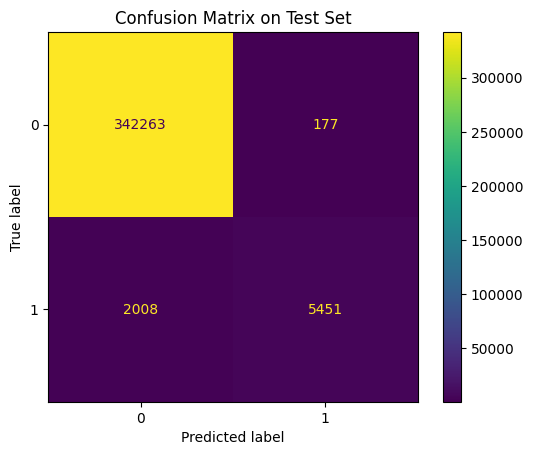

ZeroR Baseline Metrics:
  Accuracy: 0.9786824197839948
  F1 Score: 0.0
  AUC: 0.5
  Precision: 0.0
  Recall: 0.0
  AUC-PR: 0.02131758021600519


[0.9937553408269243,
 0.8330404217926186,
 0.9842274707230662,
 0.9685501066098081,
 0.7307950127362918,
 0.8990237523163386]

In [65]:
trainAndEvaluate(show=True)

We can see that XGBoost achieves good results, let's try to improve it by:
1) Balancing class weights
2) Balancing the dataset by Oversampling & Undersampling.
3) Hyperparameter Tuning.

### 1) Balancing Class Weights

In [66]:
print(len(y_train) / sum(y_train), '\n')
scales = [47, 35, 30, 25, 20, 15, 10, 9, 8, 7, 6, 5, 4, 3, 2]
results = {}
for scale in scales:
    model = XGBClassifier(scale_pos_weight= scale)
    metrics = trainAndEvaluate()
    results[scale] = metrics
    
print(f"{'Scale':<10} {'Accuracy':<10} {'F1':<10} {'AUC':<10} {'Precision':<10} {'Recall':<10} {'AUC-PR':<10}")
print("-" * 80)
for scale, metrics in results.items():
    print(f"{scale:<10} {metrics[0]:<10.2f} {metrics[1]:<10.2f} {metrics[2]:<10.2f} {metrics[3]:<10.2f} {metrics[4]:<10.2f} {metrics[5]:<10.2f}")

46.90803364949559 

Scale      Accuracy   F1         AUC        Precision  Recall     AUC-PR    
--------------------------------------------------------------------------------
47         0.97       0.58       0.99       0.43       0.92       0.89      
35         0.98       0.65       0.99       0.51       0.91       0.88      
30         0.98       0.68       0.99       0.55       0.90       0.89      
25         0.99       0.72       0.99       0.60       0.89       0.89      
20         0.99       0.76       0.99       0.67       0.89       0.89      
15         0.99       0.80       0.99       0.74       0.87       0.90      
10         0.99       0.83       0.99       0.81       0.85       0.90      
9          0.99       0.83       0.99       0.82       0.85       0.90      
8          0.99       0.84       0.99       0.84       0.85       0.90      
7          0.99       0.84       0.99       0.85       0.84       0.90      
6          0.99       0.85       0.99       0.87    

We can see that scaling positive class weights by 3 have the best performance

### 2) Balancing Dataset

- Using a balanced subset of data

In [67]:
# Create a balanced sample from the dataset
class_0 = df[df['anomaly'] == 0]
class_1 = df[df['anomaly'] == 1]

# Sample equal number from each class (based on minority class size)
min_len = min(len(class_0), len(class_1))
df_balanced = pd.concat([
    class_0.sample(min_len, random_state=42),
    class_1.sample(min_len, random_state=42)
], ignore_index=True).sample(frac=1, random_state=42)  # Shuffle

print(df_balanced['anomaly'].value_counts())

anomaly
1    37296
0    37296
Name: count, dtype: int64


In [68]:
# Separate features and target
y = df_balanced['anomaly'].values
X = df_balanced.drop(columns=['anomaly']).values

# Save meter_reading column separately
meter_reading = df_balanced['meter_reading'].values

# Scale the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test, meter_train, meter_test = train_test_split(
    X, y, meter_reading, test_size=0.1, random_state=42, stratify=y)

print(len(y_train[y_train == 1]), len(y_train[y_train == 0]))
print(len(y_test[y_test == 1]), len(y_test[y_test == 0]))

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

33566 33566
3730 3730
(67132, 29) (67132,)
(7460, 29) (7460,)


Test - Acc: 0.9442359249329759, F1: 0.9432314410480349, AUC: 0.9843060756564053, AUC-PR: 0.9867232518090975, Precision: 0.9605336297943302, Recall: 0.9265415549597855


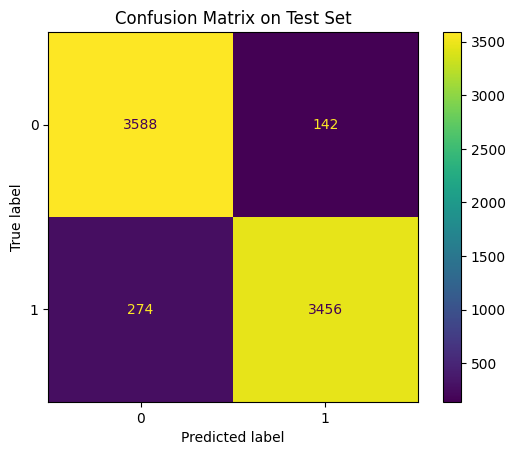

ZeroR Baseline Metrics:
  Accuracy: 0.5
  F1 Score: 0.0
  AUC: 0.5
  Precision: 0.0
  Recall: 0.0
  AUC-PR: 0.5


[0.9442359249329759,
 0.9432314410480349,
 0.9843060756564053,
 0.9605336297943302,
 0.9265415549597855,
 0.9867232518090975]

In [69]:
model = XGBClassifier()
trainAndEvaluate(show=True)

- Over-sampling

In [70]:
# Separate features and target
y = df['anomaly'].values
X = df.drop(columns=['anomaly']).values

# Save meter_reading column separately
meter_reading = df['meter_reading'].values

# Scale the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test, meter_train, meter_test = train_test_split(
    X, y, meter_reading, test_size=0.2, random_state=42, stratify=y)

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

print(len(y_train[y_train == 1]), len(y_train[y_train == 0]))
print(len(y_test[y_test == 1]), len(y_test[y_test == 0]))

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

1369758 1369758
7459 342440
(2739516, 29) (2739516,)
(349899, 29) (349899,)


Test - Acc: 0.9909059471447474, F1: 0.7637362637362637, AUC: 0.9673655127882912, AUC-PR: 0.8050173928549975, Precision: 0.8558828424030621, Recall: 0.68950261429146


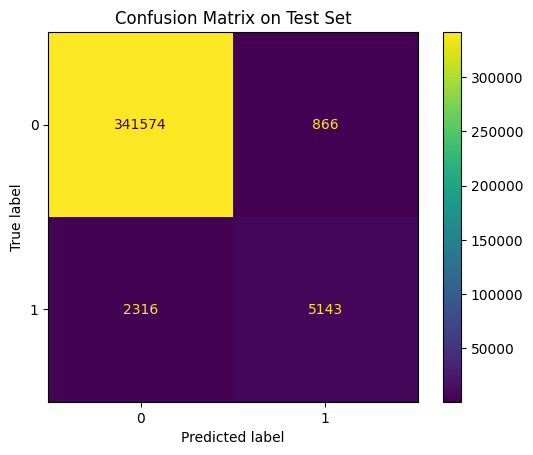

ZeroR Baseline Metrics:
  Accuracy: 0.9786824197839948
  F1 Score: 0.0
  AUC: 0.5
  Precision: 0.0
  Recall: 0.0
  AUC-PR: 0.02131758021600519


[0.9909059471447474,
 0.7637362637362637,
 0.9673655127882912,
 0.8558828424030621,
 0.68950261429146,
 0.8050173928549975]

In [71]:
model = XGBClassifier()
trainAndEvaluate(show= True)

We can see that balancing the dataset didn't help as
- Taking a small subset of data didn't make the model generalize well
- Generating synthetic data made the model overfit and generalize poorly to the imblanced test set

### 3) Hyperparameter Tuning

In [7]:
# Separate features and target
y = df['anomaly'].values
X = df.drop(columns=['anomaly']).values

# Save meter_reading column separately
meter_reading = df['meter_reading'].values

# Scale the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test, meter_train, meter_test = train_test_split(
    X, y, meter_reading, test_size=0.2, random_state=42, stratify=y)

print(len(y_train[y_train == 1]), len(y_train[y_train == 0]))
print(len(y_test[y_test == 1]), len(y_test[y_test == 0]))

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

# Hyperparameter grid
param_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 1.5, 2]
}

# Use GridSearchCV to tune hyperparameters
grid_search = GridSearchCV(XGBClassifier(scale_pos_weight=3), param_grid, scoring='f1', cv=3, verbose=1, n_jobs=-1)

# Fit model using grid search
grid_search.fit(X_train, y_train)

# Get best parameters and best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Print best parameters
print("Best Parameters: ", best_params)

# Make predictions on test set
test_pred = best_model.predict(X_test)
test_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics for test set
test_acc = accuracy_score(y_test, test_pred)
test_f1 = f1_score(y_test, test_pred)
test_auc = roc_auc_score(y_test, test_pred_proba)
test_precision = precision_score(y_test, test_pred)
test_recall = recall_score(y_test, test_pred)
test_auprc = average_precision_score(y_test, test_pred_proba)

print(f"Test - Acc: {test_acc}, F1: {test_f1}, AUC: {test_auc}, Precision: {test_precision}, Recall: {test_recall}, AUC-PR: {test_auprc}")

29837 1369758
7459 342440
(1399595, 29) (1399595,)
(349899, 29) (349899,)
Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Parameters:  {'gamma': 0, 'learning_rate': 0.1, 'reg_alpha': 1, 'reg_lambda': 1}
Test - Acc: 0.9916461607492448, F1: 0.7635304587007523, AUC: 0.9695048848904165, Precision: 0.9626682986536108, Recall: 0.6326585333154578, AUC-PR: 0.8332343164808536


We can see that the default hyperparameters with positive class weight scaling gives best results

Test - Acc: 0.9944155313390436, F1: 0.8596264367816092, AUC: 0.9876472148512245, AUC-PR: 0.9114671766985599, Precision: 0.9260176443275034, Recall: 0.8021182464137284


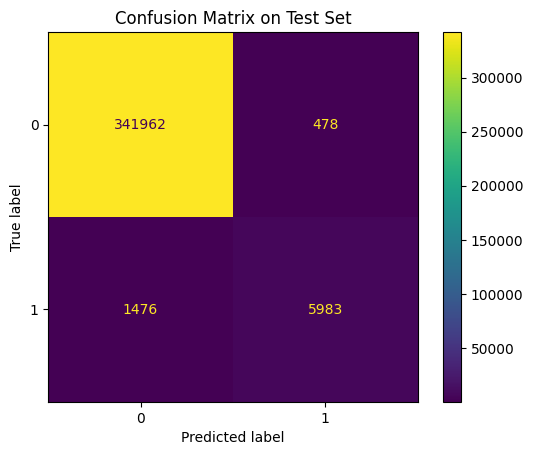

ZeroR Baseline Metrics:
  Accuracy: 0.9786824197839948
  F1 Score: 0.0
  AUC: 0.5
  Precision: 0.0
  Recall: 0.0
  AUC-PR: 0.02131758021600519


[0.9944155313390436,
 0.8596264367816092,
 0.9876472148512245,
 0.9260176443275034,
 0.8021182464137284,
 0.9114671766985599]

In [10]:
model = XGBClassifier(scale_pos_weight=3)
trainAndEvaluate(show=True)

### So our best results are with XGBoost ensemble model with:
- Accuracy = 99.44%
- F1 Score = 86%
- AUC-ROC = 98.76%
- Precision = 92.6%
- Recall = 80.2%
- AUC-PR = 91.15%

Which is better than our base zeroR model with:
- Accuracy = 97.86%
- AUC = 50%
- AUC-PR = 2.13%